In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
class LJ(object):
    '''Class to simulate LJ system'''
    
    def __init__(self, N, dim):
        self.numParticles = N
        self.dim = dim
        self.positions = np.zeros( (N,dim))
        #self.velocities = np.zeros( (N,dim))
        #self.forces = np.zeros( (N,dim))
        self.lj_sigma = 1.0
        self.lj_epsilon = 1.0
        self.kT = 1.0
        
    def position_initialization(self, boxL):
        '''initialise the positions of particles randomly, in a boxL size box '''
        self.positions = np.random.random_sample( (self.numParticles, self.dim))* boxL
        
    def velocities_MaxwellBoltzmann(self, kT):
        '''initialize velocities to Maxwell-Boltzmann distrition at temp kT'''
        factor = sqrt(kT)
        self.velocities = factor*np.random.normal(0.,1.,size=( (self.numParticles,self.dim)))
                                           
        
    def force_twoParticle_LJ(self, p_i, p_j):
        '''compute the force of interaction between particles p_i and p_j due to LJ'''
        
        rvec_ij = self.positions[p_i] - self.positions[p_j]
        d_ij = np.linalg.norm( rvec_ij )
        
        s6 = pow(self.lj_sigma/d_ij , 6) 
        
        factor = 24* self.lj_epsilon * s6 *(2 * s6 -1 )
        
        return factor*rvec_ij/pow(d_ij,2)
    
    def calcForces(self):
        ''' calcaulte the forces on all particles of the system'''
        self.forces = np.zeros( (N,dim))
        self.forces *= 0.
        
        for p_i in range(self.numParticles):
            for p_j in range(p_i):
                f_i = self.force_twoParticle_LJ(p_i, p_j)
                self.forces[p_i] += f_i
                self.forces[p_j] -= f_i
                
    def EulerIntegrate(self, dt):
        '''Euler interation with timestep dt'''
        
        self.calcForces()
        self.positions += dt * self.velocities
        self.velocities += dt * self.forces 
        
    def configDraw(self):
        figure(figsize=(5,5))
        axis = gca()
        axis.set_xlim(-5,self.boxL+5)
        axis.set_ylim(-5,self.boxL+5)
        
        circles = []
        for i in range(self.numParticles):
            circles.append( axis.add_patch( Circle(self.positions[i], radius=0.5, 
                                                   linewidth=2, edgecolor='black') ) )
            
        if(self.dim == 3):
            ax = plt.axes(projection = '3d')
            xdata = []
            xdata = [e[0] for e in self.positions]
            ydata = []
            ydata = [e[1] for e in self.positions]
            zdata = []
            zdata = [e[2] for e in self.positions]
            ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
        show()
        
    def minimize(self, dist_max):
        '''randomly selecting a particle, dispacing it randomly and 
        accept the move if energy is lower, reject otherwise'''

        p_i = np.random.randint(0,self.numParticles)
        dr = (2*np.random.random( (self.dim, ))-1)*dist_max
        
        pe_before = self.pe_interaction(p_i)
        self.positions[p_i] += dr
        pe_after = self.pe_interaction(p_i)
        
        if (pe_after > pe_before): #undo the move
            self.positions[p_i] -= dr
            
    def pe_interaction(self, p_i):
        ''' interaction energy of particle p_i with all other particles'''
        pe = 0.0
        for p_j in range(self.numParticles):
            if (p_j != p_i): 
                pe +=  self.pe_twoParticle_LJ(p_i,p_j)
        return pe
    
    def pe_twoParticle_LJ(self,p_i,p_j):
        '''LJ interaction energy between particle p_i and p_j'''
        d_ij = np.linalg.norm ( self.positions[p_i] - self.positions[p_j])
        s6 = pow(self.lj_sigma / d_ij, 6)
        return 4*self.lj_epsilon*s6*(s6-1)
    
    def totalPE(self):
        '''calculate the total potential energy of the system'''
        pe = 0.0
        for p_j in range(self.numParticles):
            for p_i in range(p_j):
                pe +=  self.pe_twoParticle_LJ(p_i,p_j)
        return pe
    
    def totalKE(self):
        '''calculate the total Kinteic Energy of the syste,'''
        return 0.5* np.sum( self.velocities **2 )
    
    
    def velocityVerletIntegrate(self,dt):
        self.calcForces()
        self.velocities += 0.5*dt*self.forces
        self.positions +=  dt*self.velocities
        self.calcForces()
        self.velocities += 0.5*dt*self.forces
        
    def Metropolis_scheme(self, dist_max):
        '''Markov Chain using Metropolis scheme.
        Randomly select a particle and displace it randomly with dist_max'''
        
        # select a particle randomly
        p_i = np.random.randint(0, self.numParticles)
        
        # select a random displacment
        dr = (2*np.random.random_sample( (self.dim,))-1)*dist_max
        
        # compute del_E
        pe_before = self.pe_interaction(p_i)
        self.positions[p_i] += dr
        pe_after = self.pe_interaction(p_i)
        del_E = pe_after - pe_before
        
        # compute accept/reject
        ## implment change in config accordingly
        prob_accept = min(1.0, np.exp(-del_E/self.kT))
        if np.random.random() > prob_accept: 
            #reject
            self.positions[p_i] -= dr
        
        return
    def virial_pressur_calc(self):
        psi = 0
        volume = np.zeros(self.dim)
        # get max position from all the axes
        for i in range(self.dim):
            volume[i] -= min(self.positions[:,i])    
            volume[i] += max(self.positions[:,i]) 
        
        vol_prod = np.prod(volume)
        abs_vol = np.absolute(vol_prod)
        volume = abs_vol
        
        for x in range (self.numParticles):
            for y in range (x):
                psi += self.force_twoParticle_LJ(x , y)
        psi = np.linalg.norm(psi)
        psi = ((self.kT*self.numParticles) + psi/(self.dim*self.numParticles))/(volume)
        return psi
    
    def calc_Temp(self):
        temperature = self.totalKE()*2/(self.kT * self.numParticles * self.dim)
        return temperature

In [5]:
s1 = LJ(64,3)
s1.boxL = 10
s1.velocities_MaxwellBoltzmann(0.001)

In [6]:
pe1 = []
v_psi = []
temp = []

In [7]:

for i in range(1000):
    s1.minimize(0.1)
    if (i%10==0):
        pe1.append(s1.totalPE())
        v_psi.append(s1.virial_pressur_calc())
        

<ipython-input-4-0df4ed30c519>:101: RuntimeWarning: divide by zero encountered in double_scalars
  s6 = pow(self.lj_sigma / d_ij, 6)
<ipython-input-4-0df4ed30c519>:30: RuntimeWarning: divide by zero encountered in double_scalars
  s6 = pow(self.lj_sigma/d_ij , 6)
<ipython-input-4-0df4ed30c519>:34: RuntimeWarning: invalid value encountered in multiply
  return factor*rvec_ij/pow(d_ij,2)


<ipython-input-4-0df4ed30c519>:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection = '3d')


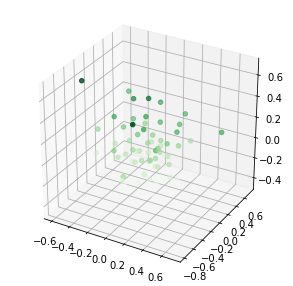

In [8]:
s1.configDraw()

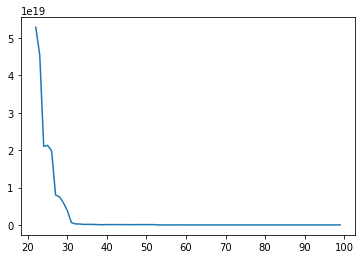

In [9]:

plot(v_psi)

In [170]:
for i in range(1000):
    s1.velocityVerletIntegrate(0.001)
    temp.append(s1.calc_Temp())

[1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323, 1.0224949144468323,

<ipython-input-11-c35c7f9da32f>:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection = '3d')


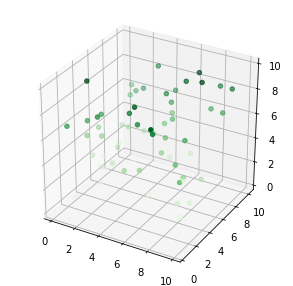

In [26]:
s1.configDraw()

In [157]:
pe2= []
psi = []
temp = []
numSteps= 10000
for step in range(numSteps):
    s1.Metropolis_scheme(0.1)
    if (step % 100 ==0):
        #ke = s1.totalKE()
        pe2.append(s1.totalPE())
        psi.append(s1.virial_pressur_calc())
        temp.append(s1.calc_Temp())
        

<ipython-input-146-5b48e82063ce>:142: RuntimeWarning: overflow encountered in exp
  prob_accept = min(1.0, np.exp(-del_E/self.kT))


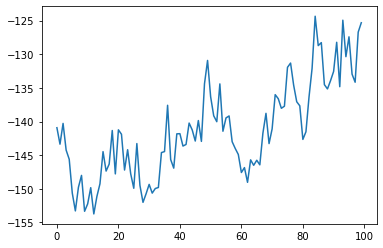

In [116]:
plot(pe2)


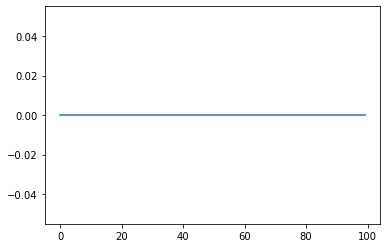

In [158]:
plot(temp)

<ipython-input-11-c35c7f9da32f>:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection = '3d')


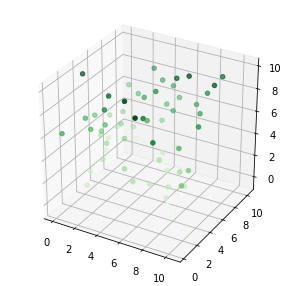

In [31]:
s1.configDraw()

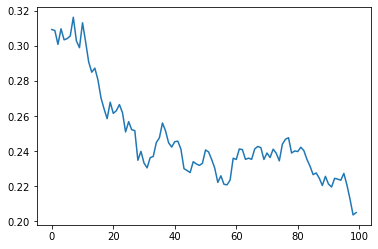

In [113]:
plot(psi)

<ipython-input-95-185c9e346e62>:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection = '3d')


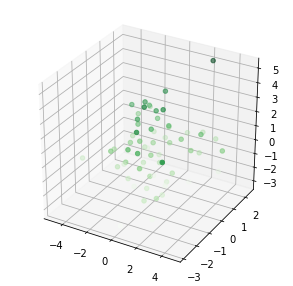

In [119]:
s1.configDraw()